In [1]:
#ToDo
#PoI - Point of Interest
#discretize the city in h3 or census
#temporal discretization (e.g., hourly, 4-hourly, daily

# Data Collection and Preperation

You have been provided with a historical dataset of taxi data – which can be assumed to be a good approximation of ride-hailing data - from Chicago, USA.
Select the year(s) that have been assigned to you and clean your dataset for use in later stages of your project. As the CSV file might be too large for your computer to open it with Python, you could preprocess the file first with tools like “sed” or “xsv” in order to filter out not needed rows and columns. To obtain hourly weather data, access the links provided above (or reach out to us). Also, provide a detailed description of the trip dataset such that there are no pending questions. Due to privacy reasons, spatial data is given only on census tract level. To better analyze location data – specifically in lower dimensions - further discretize the city in scope with the help of suitable tools (such as a matrix of hexagons using h3-Uber). This discretization is crucial for the analysis of the spatial resolution. Furthermore, you should also consider different temporal discretization (e.g., hourly, 4-hourly, daily) etc.

### Data collection

In [2]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Weather Data of the Year 2021

In [3]:
#Author: Onur Koc

Using weather data from 2016 to predict something in 2021 can result in inaccuracies, as weather patterns and conditions can vary significantly from year to year. Therefore, it is essential to use the most up-to-date weather data available to make accurate predictions.

If you use weather data from 2016, your model may not capture the variations in weather patterns that have occurred in the intervening years, which could lead to incorrect predictions. Additionally, using outdated data could result in incorrect cause-and-effect relationships, as factors that were significant in 2016 may not be as relevant in 2021.

#### NASA/POWER CERES/MERRA2 Native Resolution Hourly Data

Benefits of using NASA/POWER hourly weather data:
* many additional climate values are selectable
* location of most fleet usage can be selected, resulting in having more accurate weather data

##### POWER Hourly API Request

In [4]:
import requests

In [5]:
url= "https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,PRECTOTCORR,WS50M&community=RE&longitude=-87.6521&latitude=41.8831&start=20210101&end=20220101&format=JSON"

response = requests.get(url)

if response.status_code == 200:
    print("The request was successful")
else:
    print("Error retrieving data from API")

data = response.json()

# extract the data and convert to DataFrame
weather_df = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="columns")

# convert the index to a datetime format
weather_df.index = pd.to_datetime(weather_df.index, format="%Y%m%d%H")

# order the datetimes in ascending order
weather_df = weather_df.sort_index(ascending=True)

# rename the columns
weather_df = weather_df.rename(columns={"T2M": "temp_2m", "PRECTOTCORR": "precip", "WS50M": "windspeed_50m"})

# display the DataFrame
weather_df.head()

The request was successful


,temp_2m,precip,windspeed_50m
2020-12-31 18:00:00,-2.24,0.0,1.12
2020-12-31 19:00:00,-2.14,0.0,2.14
2020-12-31 20:00:00,-1.89,0.0,3.62
2020-12-31 21:00:00,-1.63,0.0,4.75
2020-12-31 22:00:00,-1.45,0.0,5.49


In [6]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-12-31 18:00:00 to 2022-01-01 17:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_2m        8784 non-null   float64
 1   precip         8784 non-null   float64
 2   windspeed_50m  8784 non-null   float64
dtypes: float64(3)
memory usage: 274.5 KB


**Filtering the Year 2021**

In [7]:
# filter the year 2021
weather_df = weather_df.loc['2021-01-01':'2021-12-31']

In [8]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_2m        8760 non-null   float64
 1   precip         8760 non-null   float64
 2   windspeed_50m  8760 non-null   float64
dtypes: float64(3)
memory usage: 273.8 KB


In [9]:
weather_df.index.unique()

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2021-12-31 14:00:00', '2021-12-31 15:00:00',
               '2021-12-31 16:00:00', '2021-12-31 17:00:00',
               '2021-12-31 18:00:00', '2021-12-31 19:00:00',
               '2021-12-31 20:00:00', '2021-12-31 21:00:00',
               '2021-12-31 22:00:00', '2021-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

**=> the dataset now consists of every hour of the year 2021**

In [10]:
weather_df.head(24)

,temp_2m,precip,windspeed_50m
2021-01-01 00:00:00,-1.33,0.00,6.35
2021-01-01 01:00:00,-1.28,0.00,7.12
2021-01-01 02:00:00,-1.31,0.00,7.48
2021-01-01 03:00:00,-1.16,0.00,7.30
2021-01-01 04:00:00,-0.98,0.00,7.33
2021-01-01 05:00:00,-0.77,0.00,8.15
2021-01-01 06:00:00,-0.31,0.00,9.86
2021-01-01 07:00:00,-0.07,0.00,10.21
2021-01-01 08:00:00,0.14,0.00,10.74
2021-01-01 09:00:00,0.13,0.01,10.97


### Weather Data Validation

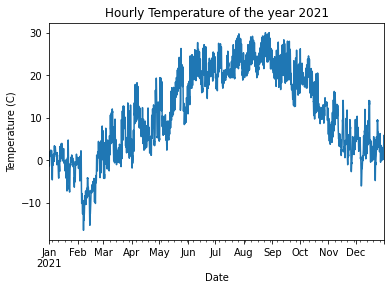

In [11]:
# plot the temperature data
weather_df["temp_2m"].plot()
plt.title("Hourly Temperature of the year 2021")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.show()

**Reference data from the Team Assignment document:**
* NOAA Online Weather Data: https://www.weather.gov/wrh/climate?wfo=lot

![image.png](attachment:9f42f944-dcc3-431b-bba9-ea62709789f4.png)    ![image.png](attachment:0b32f4b0-92fe-424d-bb34-55af5e121abe.png)


**=> the temperature graphs of both sources are very similar, so I assume that the source "NASA/POWER CERES/MERRA2 Native Resolution Hourly Data" provides valid data**



**For comparison, you can also see the temperature curve for 2016 here:**

![image.png](attachment:a4a35da6-f60e-4556-ae87-f6601d66ce67.png)      ![image.png](attachment:6c164607-e877-404d-9b41-0bd627a33888.png)

**=> Therefore, it is not advisable to use weather data from 2016 to make predictions for 2021, as there is variation in temperature data between the two years.**

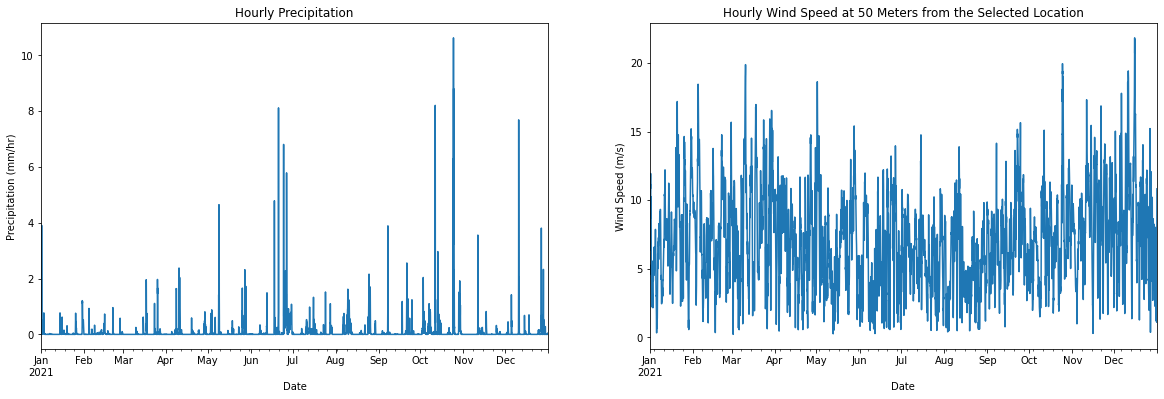

In [12]:
# create a figure with two subplots using pandas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), sharex=False)

# plot the precipitation data in the first subplot
weather_df.plot(y='precip', ax=axes[0], legend=False)
axes[0].set_title('Hourly Precipitation')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Precipitation (mm/hr)')

# plot the wind speed data in the second subplot
weather_df.plot(y='windspeed_50m', ax=axes[1], legend=False)
axes[1].set_title('Hourly Wind Speed at 50 Meters from the Selected Location')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Wind Speed (m/s)')

plt.show()

In [13]:
# convert precipitation (mm/hr) to a binary variable indicating whether it rained or not, define a threshold value like 0.4 mm/hr (slightly raining)
weather_df['precip'] = (weather_df['precip'] > 0.4).astype(int)

### Taxi Data of the Year 2021

In [14]:
# file_path = "./data/"
# taxi = pd.read_csv(f"{file_path}Taxi_Trips.csv", on_bad_lines='skip', parse_dates=["trip_start_timestamp","trip_end_timestamp"], infer_datetime_format=True,
#                    usecols =['trip_id','taxi_id','trip_start_timestamp','trip_end_timestamp','pickup_census_tract','dropoff_census_tract','pickup_community_area','dropoff_community_area',
#                              'trip_seconds','trip_miles','trip_total','company','payment_type'])

#taxi = pd.read_csv(f"{file_path}Taxi_Trips.csv", skiprows = lambda x: x not in specific_rows, infer_datetime_format=True)
#taxi = pd.read_csv(f"{file_path}Taxi_Trips.csv", parse_dates=["trip_start_timestamp","trip_end_timestamp"], infer_datetime_format=True)

In [15]:
# importing trip-data provided by the chair (takes ~30 mins but still faster than downloading data manually)

#Query to Request file from API

query = ("https://data.cityofchicago.org/resource/wrvz-psew.csv?"
    "$select=trip_id%2C%20taxi_id%2C%20trip_start_timestamp%2C%20trip_end_timestamp%2C%20pickup_census_tract%2C%20dropoff_census_tract%2C%20"
    "pickup_community_area%2C%20dropoff_community_area%2C%20trip_seconds%2C%20trip_miles%2C%20trip_total%2C%20company%2C%20payment_type"
    "&$order=trip_start_timestamp"
    "&$limit=400"
    "&$where=%28pickup_community_area%20IS%20NOT%20NULL%20OR%20dropoff_community_area%20IS%20NOT%20NULL%29%20AND%20"
    "trip_end_timestamp%20<%20%272021-12-31T23:59:59%27%20AND%20") #"&$limit=4000000"

#two requests are needed since one API request times out after 10 minutes
taxi1 = pd.read_csv(query+"trip_start_timestamp%20between%20%272021-01-01T00:00:00%27%20and%20%272021-06-30T23:59:59%27", 
                    dtype = {"pickup_community_area": object, "pickup_census_tract": object, "dropoff_community_area": object, "dropoff_census_tract": object, "trip_seconds": object}, 
                    parse_dates=["trip_start_timestamp","trip_end_timestamp"], infer_datetime_format=True)

taxi2 = pd.read_csv(query+"trip_start_timestamp%20between%20%272021-07-01T00:00:00%27%20and%20%272021-12-31T23:59:59%27", 
                    dtype = {"pickup_community_area": object, "pickup_census_tract": object, "dropoff_community_area": object, "dropoff_census_tract": object, "trip_seconds": object}, 
                    parse_dates=["trip_start_timestamp","trip_end_timestamp"], infer_datetime_format=True)

taxi = pd.concat([taxi1, taxi2])

In [21]:
#ToDo
#remove Nulls
#Converting implementing weather data per hour

taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_id                 800 non-null    object        
 1   taxi_id                 800 non-null    object        
 2   trip_start_timestamp    800 non-null    datetime64[ns]
 3   trip_end_timestamp      800 non-null    datetime64[ns]
 4   pickup_census_tract     52 non-null     object        
 5   dropoff_census_tract    36 non-null     object        
 6   pickup_community_area   758 non-null    object        
 7   dropoff_community_area  673 non-null    object        
 8   trip_seconds            800 non-null    object        
 9   trip_miles              800 non-null    float64       
 10  trip_total              800 non-null    float64       
 11  company                 800 non-null    object        
 12  payment_type            800 non-null    object    

In [24]:
#Exporting Geo Locations for h3 Mapping
query2 = ("https://data.cityofchicago.org/resource/wrvz-psew.json?"
    "$select=pickup_community_area%20AS%20Community_Area%2C%20avg%28pickup_centroid_latitude%29%20AS%20Latitude%2C%20avg%28pickup_centroid_longitude%29%20AS%20Longitude"
    "&$where=trip_start_timestamp%20between%20%272021-01-01T00:00:00%27%20and%20%272021-12-31T23:59:59%27%20AND%20pickup_community_area%20IS%20NOT%20NULL"
    "&$order=pickup_community_area"
    "&$group=pickup_community_area")
community_centroid = pd.read_json(query2, dtype = {"pickup_community_area": object})
community_centroid.info()
community_centroid.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Community_Area  77 non-null     int64  
 1   Latitude        77 non-null     float64
 2   Longitude       77 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


,Community_Area,Latitude,Longitude
0,1,42.009623,-87.670164
1,2,42.001557,-87.694980
2,3,41.965770,-87.655779
3,4,41.975181,-87.687552
4,5,41.947786,-87.683834
5,6,41.944198,-87.655759
6,7,41.922476,-87.648736
7,8,41.897672,-87.629374
8,9,42.007608,-87.813780
9,10,41.985013,-87.804536


In [25]:
file_path = "./data/"
community_centroid.to_csv(f"{file_path}chicago_community_centroid.csv", index=False)
del community_centroid

In [ ]:
# taking a look at the taxi data
print("number of rows in taxi data:", len(taxi))
taxi.head(10000000)

number of rows in taxi data: 3753630


,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,NaN,4,1021,3.17,13.25,Flash Cab,Cash
1,33eb5c7a1439ac1e3ec6d1520e21db8137d1d11b,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01 00:00:00,2021-01-01 15:30:00,NaN,NaN,56,NaN,56047,7.10,27.00,Flash Cab,Cash
2,4bcfcfa78f372b705214ee2cba9c765ad6ba5161,31261f6e7fc645eff98c7964c7ea71a0ea7e387a6bd7f8...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8,8,120,0.10,4.50,Taxi Affiliation Services,Cash
3,655bbd9bcb0a78ee003e304ebbe350b21cdd7083,f6138aa35e1fb074eb79fbe29f512b6153dca3593d8cd2...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,67,67,0,0.00,3.25,"Taxicab Insurance Agency, LLC",Cash
4,7b7b8108de94a518607068a7369ceea1ab2ae924,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,60,31,50,0.38,4.00,Flash Cab,Cash
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477882,c14dc634692954ed3a894758160038be74d5d9a7,271cde2c4b4cc7b38a86c7e9b1543474230949e7fa5925...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,NaN,24,26,0.00,40.00,Sun Taxi,Cash
2477883,c7f7d10621b9125d15a6d18157bc397e3d340962,5da013ec65199c182be94d5f8a640d1f0981620378d3f0...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,8,6,740,2.78,10.75,24 Seven Taxi,Cash
2477884,d2a963bc462f633f0c86db68b54f4fa56a1279a4,8f4cde3f6d55c38289233d1679f415c644227354939888...,2021-12-31 23:45:00,2021-12-31 23:45:00,17031081300,17031081300,8,8,43,0.00,3.25,Chicago Independents,Cash
2477885,d5c90abb02cd46d0271e4fa0dd6f72c2157f3e5a,f81c929ea7d9107e6de8bd7ee335f42563b3413e967e98...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,32,8,660,0.90,8.75,Taxi Affiliation Services,Cash
